## Extract TLD in ont Fingerprinting scripts

This notebook extracts the TLDs in Font Fingerprinting scripts. The heuristics to find out the Font Fingerprinting scripts is directly taken from [2019_03_willougr_fingerprinting_implementation_sixth_sense/Font Fingerprinting Heuristics](https://github.com/mozilla/overscripted/blob/master/analyses/2019_03_willougr_fingerprinting_implementation_sixth_sense/Font%20Fingerprinting%20Heuristics.ipynb).

In [1]:
import dask.dataframe as dd
import re
import json

from dask.distributed import Client, progress
from collections import defaultdict

DATA_DIR = 'YOUR DATA DIRECTORY HERE'
DATA_DIR_FULL = '/home/soumya/Dataset/sample_0.parquet'
Client()

/home/soumya/.conda/envs/overscripted/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/soumya/.conda/envs/overscripted/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/soumya/.conda/envs/overscripted/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:37079 Dashboard: http://127.0.0.1:43379/status,Cluster Workers: 4 Cores: 12 Memory: 8.25 GB


## Setup

In [2]:
df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'symbol', 'value', 'location', 'argument_0'])
df.head()

,script_url,symbol,value,location,argument_0
call_id,,,,,
1_00006011493ed94fb8010cead84ee610cdbece5de961abe96f0cba54.json__0,https://vk.com/js/api/xdm.js?1449919642,window.name,fXDcab74,https://vk.com/widget_comments.php?app=2297596...,None
1_00006011493ed94fb8010cead84ee610cdbece5de961abe96f0cba54.json__1,https://vk.com/js/api/xdm.js?1449919642,window.name,fXDcab74,https://vk.com/widget_comments.php?app=2297596...,None
1_00006011493ed94fb8010cead84ee610cdbece5de961abe96f0cba54.json__2,https://vk.com/js/al/aes_light.js?592436914,window.navigator.userAgent,Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko...,https://vk.com/widget_comments.php?app=2297596...,None
1_00006b1ad6ce7a5b2b81a8ef96f0778853ea6d81a97693d85a52790c.json__0,https://cpro.baidustatic.com/cpro/ui/noexpire/...,window.navigator.userAgent,Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko...,https://pos.baidu.com/s?hei=70&wid=670&di=u313...,None
1_0000813d43acf1fe219ada01597cfb1d5dc9c12b61f343c6cfac362b.json__0,https://apis.google.com/js/plusone.js?_=151338...,window.document.cookie,_ga=GA1.2.1529583939.1513387469; _gid=GA1.2.17...,http://serienjunkies.org/smilf/smilf-season-1-...,None


## Candidate URLs for 'CanvasRenderingContext2D.font'

In [3]:
font_df_sixth_sense = df[df.symbol == 'CanvasRenderingContext2D.font']
font_df_sixth_sense = font_df_sixth_sense[['value', 'script_url', 'location']]
font_df_sixth_sense = font_df_sixth_sense.drop_duplicates().persist()
progress(font_df_sixth_sense, notebook=False)

/home/soumya/.local/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [4]:
font_df_sixth_sense = font_df_sixth_sense.compute()
font_df_sixth_sense.head()

,value,script_url,location
call_id,,,
1_00022de65942197e3855f68b373c5a2710eefe66945e40063c30419f.json__268,11pt Arial,https://www.coches.net/ztkieflaaxcvaiwh121837.js,https://www.coches.net/fiat/segunda-mano/
1_00022de65942197e3855f68b373c5a2710eefe66945e40063c30419f.json__271,18pt Arial,https://www.coches.net/ztkieflaaxcvaiwh121837.js,https://www.coches.net/fiat/segunda-mano/
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__353,7px 'sans-serif',http://static.mvideo.ru/media/js/mvideo.js?v0.7,http://www.mvideo.ru/aksessuary-dlya-avtomobil...
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__358,7px 'Abadi MT Condensed',http://static.mvideo.ru/media/js/mvideo.js?v0.7,http://www.mvideo.ru/aksessuary-dlya-avtomobil...
1_0004d550953191c5723947694ac872f7e277d94041ae0112ffa577fd.json__363,7px 'Adobe Fan Heiti Std',http://static.mvideo.ru/media/js/mvideo.js?v0.7,http://www.mvideo.ru/aksessuary-dlya-avtomobil...


In [5]:
%%time

num_fonts_sixth_sense = defaultdict(set)
    
for index, row in font_df_sixth_sense.iterrows():
    num_fonts_sixth_sense[(row.script_url, row.location)].add(row.value)

CPU times: user 5.28 s, sys: 156 ms, total: 5.44 s
Wall time: 5.52 s


In [6]:
font_urls_not_enough_sixth_sense = [x for x, font_set in num_fonts_sixth_sense.items() if len(font_set) < 50]
font_urls_candidates_sixth_sense = [x for x, font_set in num_fonts_sixth_sense.items() if len(font_set) >= 50]

In [7]:
print('# of unique tuples (script_url, location) with 50 or more calls:', len(font_urls_candidates_sixth_sense))
print('# of unique tuples (script_url, location) with less than 50:', len(font_urls_not_enough_sixth_sense))

# of unique tuples (script_url, location) with 50 or more calls: 227
# of unique tuples (script_url, location) with less than 50: 5918


In [8]:
with open('not_font_fingerprinting_1.json', 'w') as f:
    f.write(json.dumps(list(set([script_url for script_url, location in font_urls_not_enough_sixth_sense]))))

## Candidate URLs for 'CanvasRenderingContext2D.measureText'

In [9]:
measure_text_df_sixth_sense = df[df.symbol == 'CanvasRenderingContext2D.measureText']
measure_text_df_sixth_sense = measure_text_df_sixth_sense[['argument_0', 'script_url', 'location']]
measure_text_df_sixth_sense['to_count'] = 1
measure_text_df_sixth_sense = measure_text_df_sixth_sense.groupby(['argument_0', 'script_url', 'location']).count().persist()
progress(measure_text_df_sixth_sense, notebook=False)

In [10]:
measure_text_df_sixth_sense = measure_text_df_sixth_sense.compute()
measure_text_df_sixth_sense = measure_text_df_sixth_sense.reset_index('argument_0', drop=True)
measure_text_df_sixth_sense.head()

to_count
script_url                                         location                                  
http://sspy-up.gov.in/fusioncharts/js/fusioncha... http://sspy-up.gov.in/index.aspx        10
                                                   http://sspy-up.gov.in/index.aspx        10
                                                   http://sspy-up.gov.in/index.aspx         2
                                                   http://sspy-up.gov.in/index.aspx         2
                                                   http://sspy-up.gov.in/index.aspx         2

In [11]:
measure_text_not_enough_df_sixth_sense = measure_text_df_sixth_sense[measure_text_df_sixth_sense['to_count'] < 50]

In [12]:
measure_text_df_sixth_sense = measure_text_df_sixth_sense[measure_text_df_sixth_sense['to_count'] >= 50]

In [13]:
measure_text_urls_candidates_sixth_sense = set(measure_text_df_sixth_sense.index.tolist())
measure_text_urls_not_enough_sixth_sense = set(measure_text_not_enough_df_sixth_sense.index.tolist())

In [14]:
print('# of unique tuples (script_url, location) with 50 or more calls:', len(measure_text_urls_candidates_sixth_sense))
print('# of unique tuples (script_url, location) with less than 50:', len(measure_text_urls_not_enough_sixth_sense))

# of unique tuples (script_url, location) with 50 or more calls: 245
# of unique tuples (script_url, location) with less than 50: 250


In [15]:
with open('not_font_fingerprinting_2.json', 'w') as f:
    f.write(json.dumps(list(set([script_url for script_url, location in measure_text_urls_not_enough_sixth_sense]))))

## Cross reference lists

In [16]:
font_urls_candidates_sixth_sense = set(font_urls_candidates_sixth_sense)

all_candidate_urls_sixth_sense = font_urls_candidates_sixth_sense | measure_text_urls_candidates_sixth_sense
canvas_font_fp_urls_sixth_sense = font_urls_candidates_sixth_sense & measure_text_urls_candidates_sixth_sense

print('# of unique tuples (script_url, location) meeting both criteria:', len(canvas_font_fp_urls_sixth_sense))
print('# of unique tuples (script_url, location) that only meet one criteria:', len(all_candidate_urls_sixth_sense - canvas_font_fp_urls_sixth_sense))

# of unique tuples (script_url, location) meeting both criteria: 199
# of unique tuples (script_url, location) that only meet one criteria: 74


In [17]:
with open('not_font_fingerprinting_3.json', 'w') as f:
    f.write(json.dumps(list(set([script_url for script_url, location in (all_candidate_urls_sixth_sense - canvas_font_fp_urls_sixth_sense)]))))

## Save Candidate URLs

In [18]:
with open('font_fingerprinting.json', 'w') as f:
    f.write(json.dumps(list(set([script_url for script_url, location in canvas_font_fp_urls_sixth_sense]))))

## Find Locations

In [19]:
with open('font_fingerprinting.json', 'r') as f:
    font_fp_urls = json.load(f)
    
print(len(font_fp_urls), '== 1387')

165 == 1387


In [20]:
df = dd.read_parquet(DATA_DIR_FULL, columns=['script_url', 'location'])

In [21]:
df_locs = df[df.script_url.isin(font_fp_urls)]
locs = df_locs.location.unique().persist()
progress(locs, notebook=False)

In [22]:
print('# of locations that call audio fingerprinting scripts:', len(locs))

# of locations that call audio fingerprinting scripts: 229


In [23]:
font_fp_urls[0:5]

['https://m.stripe.network/inner.html#referrer=&title=Atlas%20Neck%20Brace%E2%84%A2%20%7C%20Engineered%20flexibility.&url=http%3A%2F%2Fwww.atlasbrace.com%2F&muid=f1ba4b11-0d12-4657-8b8b-2b90b0b0ac48&sid=e9c96990-16c2-47cf-88f3-638e678cbc0a&preview=false&',
 'https://m.stripe.network/inner.html#referrer=&title=Delivery%20in%20Boston%20-%20Postmates%20On-Demand%20Delivery&url=https%3A%2F%2Fpostmates.com%2Fcity%2Fboston&muid=0e6fba25-d178-4fc2-98b2-c93a95c76e58&sid=9ce336bf-0fa3-43cf-a476-781ee4683c53&preview=false&',
 'https://m.stripe.network/inner.html#url=https%3A%2F%2Fwww.wappalyzer.com%2Fapplications%2Fsalesforce&title=Wappalyzer%20-%20Websites%20using%20Salesforce&referrer=&muid=0bf77e67-1a4a-4e23-95c8-2d2b031a8c79&sid=c8985cee-faa5-4b9e-9d25-65116b96e624&preview=false',
 'https://m.stripe.network/inner.html#referrer=&title=Tote%20Bags%20T-shirts%20%7C%20Unique%20Tote%20Bags%20Apparel%20%7C%20Teespring&url=https%3A%2F%2Fteespring.com%2Fshop%2Ftote-bags-tshirts%3Ftsmac%3Dmarketplace

## Extract TLD

In [24]:
import tldextract
opsuffix=[]
opurls=[]
for i in range(len(font_fp_urls)):
    opurls.append(tldextract.extract(font_fp_urls[i]))
    opsuffix.append(opurls[i].suffix)
print(opsuffix)

['network', 'network', 'network', 'network', 'com', 'network', 'com', 'network', 'network', 'com', 'net', 'network', 'network', 'network', 'network', 'network', 'network', 'network', 'network', 'network', 'net', 'network', 'com', 'com', 'network', 'network', 'network', 'network', 'network', 'com', 'network', 'com', 'network', 'network', 'network', 'network', 'net', 'network', 'network', 'network', 'network', 'network', 'com', 'network', 'network', 'network', 'com', 'network', 'network', 'network', 'network', 'network', 'com', 'com', 'network', 'com', 'network', 'com', 'network', 'network', 'com', 'vn', 'network', 'network', 'network', 'com', 'com', 'com', 'com', 'network', 'vn', 'network', 'network', 'com', 'network', 'network', 'network', 'network', 'com', 'com', 'network', 'network', 'network', 'com', 'network', 'com', 'com', 'com', 'network', 'network', 'network', 'network', 'network', 'com', 'com', 'network', 'com', 'network', 'network', 'com', 'network', 'network', 'network', 'com

In [25]:
len(font_fp_urls)

165

## Frequency of each TLD

In [26]:
import collections
for i in range(len(opsuffix)):
    counter=collections.Counter(opsuffix)
print(counter)

Counter({'network': 110, 'com': 49, 'net': 4, 'vn': 2})


In [27]:
len(counter)

4

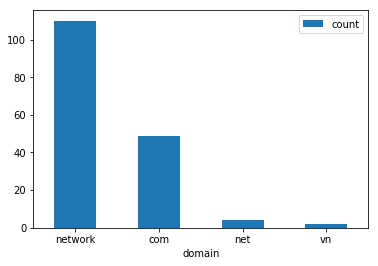

In [29]:
import pandas as pd
dfplot = pd.DataFrame({'domain':['network','com','net','vn'], 'count':[110,49,4,2]})
ax = dfplot.plot.bar(x='domain', y='count', rot=0)